In [8]:
import cv2
import numpy as np
from IPython.display import Image, display

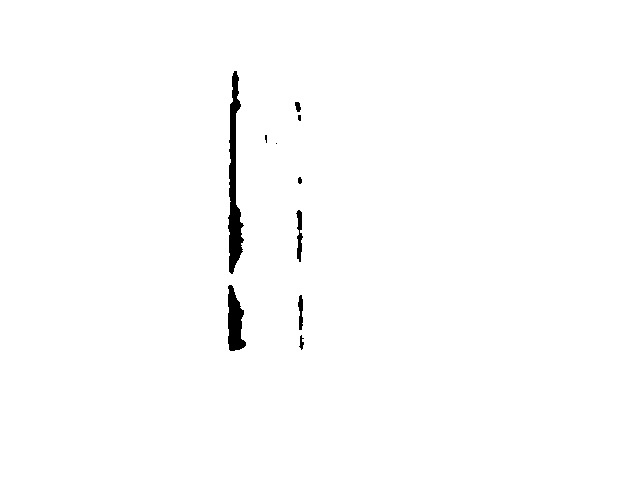

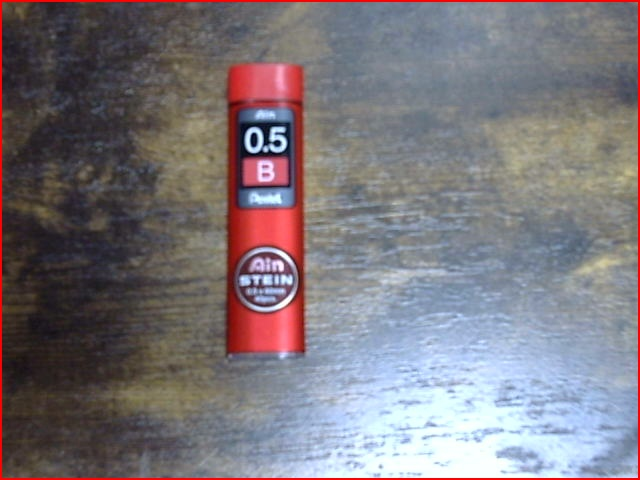

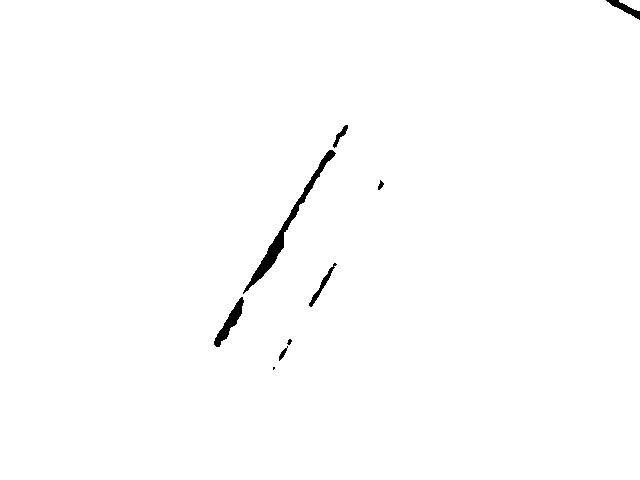

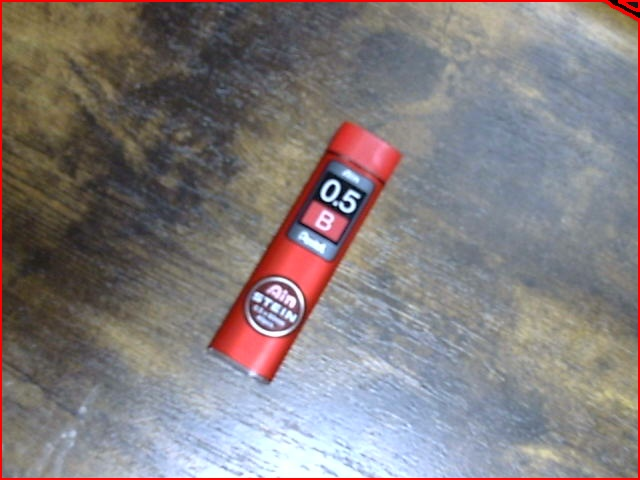

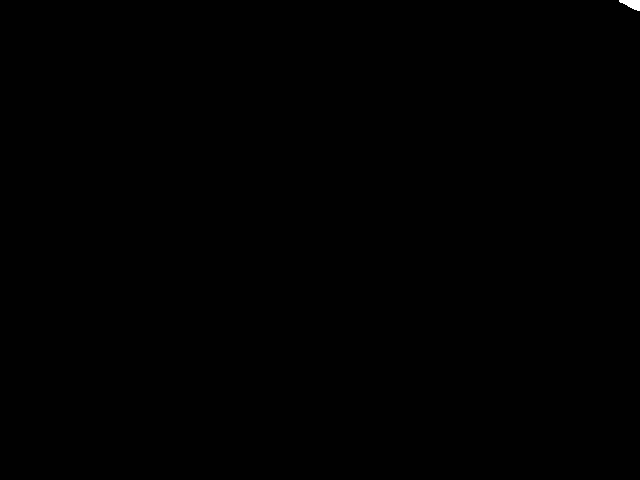

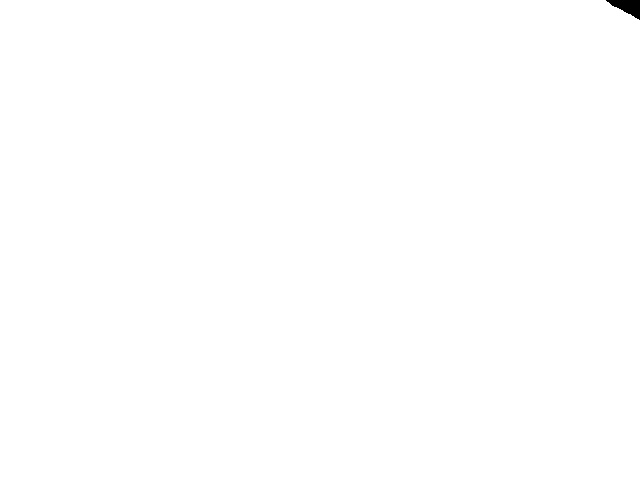

In [9]:
def imshow(img):
    """ndarray 配列をインラインで Notebook 上に表示する。
    """
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))


def get_contours(img):
    # HSV 色空間に変換する。
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 2値化する。
    bin_img = cv2.inRange(hsv, (0, 0, 0), (255, 200, 255))

    # 輪郭を滑らかにする。
    bin_img = cv2.medianBlur(bin_img, 5)
    imshow(bin_img)

    # 輪郭を抽出する。
    contours, hierarchy = cv2.findContours(
        bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # 面積が小さい輪郭は除去する。
    contours = list(filter(lambda x: cv2.contourArea(x) > 100, contours))

    # 輪郭抽出の結果を描画する。
    dst = cv2.drawContours(img.copy(), contours, -1, color=(0, 0, 255), thickness=2)
    imshow(dst)

    return contours


# 画像を読み込む。
train_img = cv2.imread("./image.png")  # 探したい物体
query_img = cv2.imread("./image2.png")

# 輪郭を抽出する。
train_contours = get_contours(train_img)
query_contours = get_contours(query_img)

# 検出結果を格納するオブジェクト
train_obj = {"contour": train_contours[0]}
query_objs = [{"contour": x} for x in query_contours]

# 各物体のマスクを作成する。
for obj in query_objs:
    # 輪郭内部を255、それ以外を0としたマスク画像を作成する。
    mask = np.ones(train_img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [obj["contour"]], -1, color=255, thickness=-1)
    imshow(mask)

    obj["mask"] = mask

In [10]:
# OBR 特徴量検出器を作成する。
detector = cv2.ORB_create()

# 探したい物体の特徴点及び特徴量記述子を計算する。
train_kp, train_desc = detector.detectAndCompute(train_img, None)

# 検出対象の画像の物体の特徴点及び特徴量記述子を計算する。
for obj in query_objs:
    obj["kp"], obj["desc"] = detector.detectAndCompute(query_img, obj["mask"])

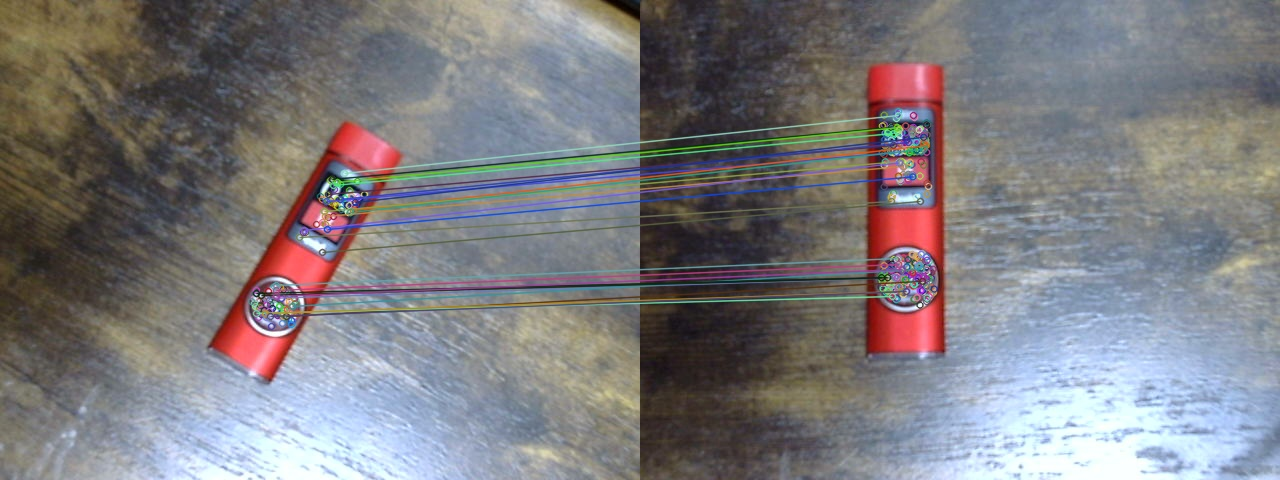

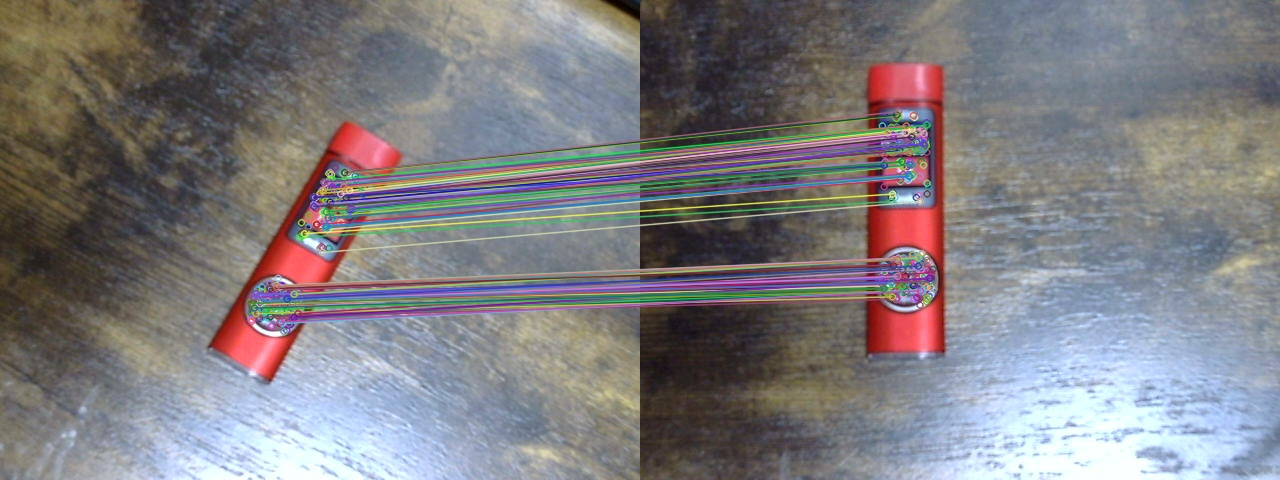

In [11]:
# マッチング器を作成する。
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

for obj in query_objs:
    # 特徴点マッチングを行う。
    matches = bf.knnMatch(obj["desc"], train_desc, k=2)

    # レシオテストを行う。
    good_matches = []
    for first, second in matches:
        if first.distance < second.distance * 0.7:
            good_matches.append(first)

    # マッチング結果を描画する。
    dst = cv2.drawMatches(query_img, obj["kp"], train_img, train_kp, good_matches, None)
    imshow(dst)

    if len(good_matches) > 100:
        # 十分な数のマッチングが存在する場合、同一物体と判定する。
        obj["is_target"] = True

        # マッチした特徴点を格納する。
        obj["match_query_kp"] = np.array(
            [obj["kp"][x.queryIdx].pt for x in good_matches]
        )
        obj["match_train_kp"] = np.array(
            [train_kp[x.trainIdx].pt for x in good_matches]
        )
    else:
        obj["is_target"] = False

# 検出できた物体だけ残す
query_objs = [x for x in query_objs if x["is_target"]]

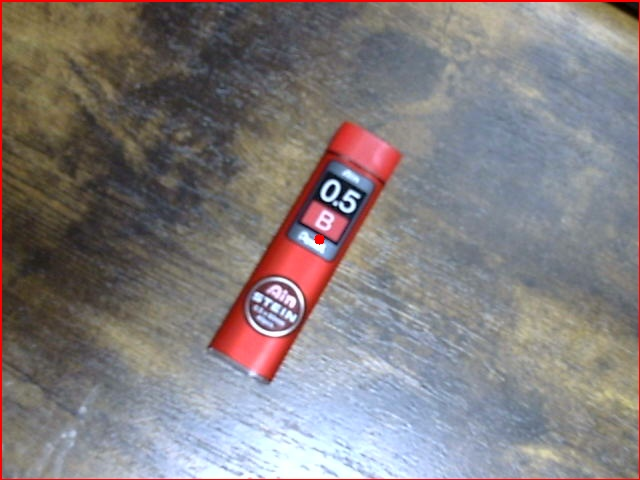

In [12]:
def get_rect(contour):
    # 輪郭の外接矩形を取得する。
    x, y, w, h = cv2.boundingRect(contour)
    # 輪郭のモーメントを計算する。
    M = cv2.moments(contour)
    # モーメントから重心を計算する。
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]

    return {"tl": (x, y), "br": (x + w, y + h), "center": (cx, cy)}


def to_int_tuple(pt):
    return tuple(int(x) for x in pt)


train_obj.update(get_rect(train_obj["contour"]))
for obj in query_objs:
    obj.update(get_rect(obj["contour"]))

# 外接矩形及び重心を描画する。
dst = query_img.copy()
for obj in query_objs:
    # 矩形を描画する。
    cv2.rectangle(dst, obj["tl"], obj["br"], color=(0, 0, 255), thickness=2)
    # 中心を描画する。
    cv2.circle(dst, to_int_tuple(obj["center"]), 5, color=(0, 0, 255), thickness=-1)
imshow(dst)

In [13]:
def calc_pose(query_kp, train_kp):
    query_kp = np.reshape(query_kp, (-1, 1, 2))
    train_kp = np.reshape(train_kp, (-1, 1, 2))

    # ホモグラフィー行列を求める。
    A, inliers = cv2.estimateAffinePartial2D(train_kp, query_kp)

    # 行列から平行移動量を求める。
    M = A[:2, :2]
    t = A[:, 2]
    # 行列から回転角度を求める。
    degree = np.rad2deg(-np.arctan2(A[0, 1], A[0, 0]))

    return {"angle": degree, "M": M, "t": t}


for obj in query_objs:
    obj.update(calc_pose(obj["match_query_kp"], obj["match_train_kp"]))

# print(train_img.shape)
print(query_img.shape)

# 平行移動及び回転角度を描画する。
img = cv2.addWeighted(train_img, 0.5, query_img, 0.5, 0)

for obj in query_objs:
    src = np.array(train_obj["center"])

    # 移動前の点に推定したアフィン変換 M x + b を適用する。
    dst = obj["M"] @ src + obj["t"]

    # アフィン変換後の点及び回転量を描画して、合っていることを確かめる。

    # アフィン変換後の点を描画する。
    cv2.arrowedLine(
        img, to_int_tuple(src), to_int_tuple(dst), color=(0, 0, 255), thickness=2
    )

    # 回転量を描画する。
    cv2.ellipse(
        img,
        to_int_tuple(dst),
        (20, 20),
        angle=0,
        startAngle=0,
        endAngle=obj["angle"],
        color=(0, 0, 0),
        thickness=-1,
    )
imshow(img)